# GPU 할당

In [1]:
import tensorflow as tf 
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [2]:
import os
import warnings
warnings.filterwarnings(action='ignore')

os.environ["CUDA_VISIBLE_DEVICES"]="0" # GPU 할당

In [3]:
pwd

'C:\\Users\\wogml\\anaconda3\\A_science\\1. dacon_basic_img'

# train dataset

In [4]:
#create training dataset
from glob import glob
import numpy as np
import PIL
from PIL import Image

path = './data/train/'

training_images = []
training_labels = []

for filename in glob(path +"*"):
    for img in glob(filename + "/*.jpg"):
        an_img = PIL.Image.open(img) #read img
        img_array = np.array(an_img) #img to array
        training_images.append(img_array) #append array to training_images
        label = filename.split('\\')[-1] #get label
        training_labels.append(label) #append label
        
training_images = np.array(training_images)
training_labels = np.array(training_labels)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
training_labels= le.fit_transform(training_labels)
training_labels = training_labels.reshape(-1,1)

print(training_images.shape)
print(training_labels.shape)

(50000, 32, 32, 3)
(50000, 1)


# test dataset

In [5]:
path = './data/test/'

test_images = []
test_idx = []

flist = sorted(glob(path + '*.jpg'))

for filename in flist:
    an_img = PIL.Image.open(filename) #read img
    img_array = np.array(an_img) #img to array
    test_images.append(img_array) #append array to training_images 
    label = filename.split('\\')[-1] #get id 
    test_idx.append(label) #append id
    
test_images = np.array(test_images)

print(test_images.shape)
print(test_idx[0:5])

(10000, 32, 32, 3)
['0000.jpg', '0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg']


# 데이터 라벨 확인

In [6]:
label_num = [0,1,2,3,4,5,6,7,8,9]
label_name = le.inverse_transform(label_num)

for i in range(10):
    print(label_num[i], label_name[i])

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


# imageDataGenerator

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

tf.random.set_seed(42)

image_generator = ImageDataGenerator(
    rotation_range=30,
    brightness_range = [0.8, 1.0],
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)

In [25]:
augment_size=200000 #10만개 생성

np.random.seed(42)

random_mask = np.random.randint(training_images.shape[0], size=augment_size)
training_image_aug = training_images[random_mask].copy()
training_labels_aug = training_labels[random_mask].copy()

In [26]:
training_image_aug = image_generator.flow(training_image_aug, np.zeros(augment_size), batch_size=augment_size, shuffle=False, seed = 42).next()[0]

training_images = np.concatenate((training_images, training_image_aug)) #training에 생성한 데이터 추가
training_labels = np.concatenate((training_labels, training_labels_aug)) 

In [27]:
print(training_images.shape)
print(training_labels.shape)

(350000, 32, 32, 3)
(350000, 1)


# 데이터 변환

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(training_images, 
                                                      training_labels, 
                                                      test_size=0.05, 
                                                      stratify = training_labels, 
                                                      random_state=42)
X_test = test_images

In [29]:
print('X_train 크기:',X_train.shape)
print('y_train 크기:',y_train.shape)
print('X_valid 크기:',X_valid.shape)
print('y_valid 크기:',y_valid.shape)
print('X_test  크기:',X_test.shape)

X_train 크기: (332500, 32, 32, 3)
y_train 크기: (332500, 1)
X_valid 크기: (17500, 32, 32, 3)
y_valid 크기: (17500, 1)
X_test  크기: (10000, 32, 32, 3)


In [30]:
X_train = X_train / 255.0
X_valid = X_valid / 255.0
X_test = X_test / 255.0

# 모델링

In [31]:
output_channel = [512/8, 512/4, 512/2, 512]

In [32]:
import tensorflow as tf
from tensorflow.keras import layers

def VGG16_model():
    tf.random.set_seed(2)
    
    output_channel = [512/8, 512/4, 512/2, 512]
    model = tf.keras.models.Sequential([
        # Conv 1
        layers.Conv2D(output_channel[0], (3, 3), strides=1, padding='same', activation='relu',
        input_shape=(32,32,3), name='conv1_1'),
        layers.Conv2D(output_channel[0], (3, 3), strides=1, padding='same', activation='relu', name='conv1_2'),
        layers.MaxPool2D((2,2), padding='same', name='conv1_MaxPool'),
        layers.BatchNormalization(),
        # Conv 2
        layers.Conv2D(output_channel[1], (3, 3), strides=1, padding='same', activation='relu', name='conv2_1'),
        layers.Conv2D(output_channel[1], (3, 3), strides=1, padding='same', activation='relu', name='conv2_2'),
        layers.MaxPool2D((2,2), padding='same', name='conv2_MaxPool'),
        layers.BatchNormalization(),
        # Conv3
        layers.Conv2D(output_channel[2], (3, 3), strides=1, padding='same', activation='relu', name='conv3_1'),
        layers.Conv2D(output_channel[2], (3, 3), strides=1, padding='same', activation='relu', name='conv3_2'),
        layers.Conv2D(output_channel[2], (3, 3), strides=1, padding='same', activation='relu', name='conv3_3'),
        layers.MaxPool2D((2,2), padding='same', name='conv3_MaxPool'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        # Conv4
        layers.Conv2D(output_channel[3], (3, 3), strides=1, padding='same', activation='relu', name='conv4_1'),
        layers.Conv2D(output_channel[3], (3, 3), strides=1, padding='same', activation='relu', name='conv4_2'),
        layers.Conv2D(output_channel[3], (3, 3), strides=1, padding='same', activation='relu', name='conv4_3'),
        layers.MaxPool2D((2,2), padding='same', name='conv4_MaxPool'),
        layers.BatchNormalization(),
        # Conv5
        layers.Conv2D(output_channel[3], (3, 3), strides=1, padding='same', activation='relu', name='conv5_1'),
        layers.Conv2D(output_channel[3], (3, 3), strides=1, padding='same', activation='relu', name='conv5_2'),
        layers.Conv2D(output_channel[3], (3, 3), strides=1, padding='same', activation='relu', name='conv5_3'),
        layers.MaxPool2D((2,2), padding='same', name='conv5_MaxPool'),
        layers.BatchNormalization(),
        # Flatten
        layers.GlobalAveragePooling2D(),
        # Dropout
        layers.Dropout(0.5),
        # FC1
        layers.Dense(output_channel[2], activation='relu'),
        # output
        layers.Dense(10, activation='softmax'),
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['acc'])
    
    return model

In [33]:
vgg_16 = VGG16_model()
vgg_16.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 32, 32, 64)        1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 32, 32, 64)        36928     
_________________________________________________________________
conv1_MaxPool (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
conv2_1 (Conv2D)             (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 16, 16, 128)       147584    
_________________________________________________________________
conv2_MaxPool (MaxPooling2D) (None, 8, 8, 128)        

# model fit

In [34]:
from tensorflow import keras
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


In [35]:
img_fit = vgg_16.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, batch_size=128,
                    callbacks = [early_stop])

Epoch 1/100
2598/2598 [==============================] - 172s 66ms/step - loss: 1.6625 - acc: 0.3952 - val_loss: 2.1390 - val_acc: 0.3374
Epoch 2/100
2598/2598 [==============================] - 157s 61ms/step - loss: 1.2506 - acc: 0.5585 - val_loss: 1.1107 - val_acc: 0.6142
Epoch 3/100
2598/2598 [==============================] - 158s 61ms/step - loss: 0.9623 - acc: 0.6691 - val_loss: 0.9268 - val_acc: 0.6874
Epoch 4/100
2598/2598 [==============================] - 155s 60ms/step - loss: 0.7653 - acc: 0.7397 - val_loss: 0.7536 - val_acc: 0.7423
Epoch 5/100
2598/2598 [==============================] - 152s 58ms/step - loss: 0.6347 - acc: 0.7849 - val_loss: 0.6810 - val_acc: 0.7686
Epoch 6/100
2598/2598 [==============================] - 156s 60ms/step - loss: 0.5364 - acc: 0.8177 - val_loss: 0.7015 - val_acc: 0.7636
Epoch 7/100
2598/2598 [==============================] - 153s 59ms/step - loss: 0.4588 - acc: 0.8445 - val_loss: 0.5889 - val_acc: 0.8027
Epoch 8/100
2598/2598 [===========

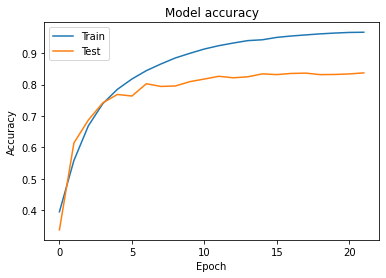

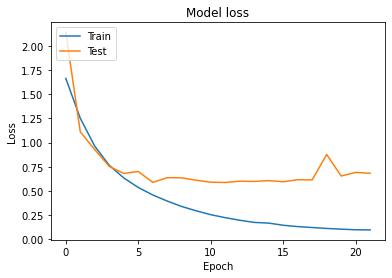

In [36]:
import matplotlib.pyplot as plot

plot.plot(img_fit.history['acc'])
plot.plot(img_fit.history['val_acc'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

plot.plot(img_fit.history['loss'])
plot.plot(img_fit.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

# 추론

In [37]:
import pandas as pd

**TTA 활용**

In [45]:
X_test_ori = test_images
X_test = test_images
X_test = X_test / 255.0

pred_proba = vgg_16.predict(X_test)

#TTA 적용
for i in [1, 2, 3, 4]:
    X_test_aug = image_generator.flow(X_test_ori, np.zeros(10000), batch_size=10000, shuffle=False, seed = 42^i).next()[0]
    X_test_aug = X_test_aug / 255.0
    pred_proba_aug = vgg_16.predict(X_test_aug)
    pred_proba = np.add(pred_proba, pred_proba_aug)
    
pred_class = []

for i in pred_proba:
    pred = np.argmax(i)
    pred_class.append(pred)
    
pred_class = le.inverse_transform(pred_class)
pred_class[0:5]

array(['horse', 'airplane', 'airplane', 'horse', 'airplane'], dtype='<U10')

* np.zeros() 0으로 가득 찬 array를 생성합니다.
* np.argmax() 다차원 배열의 경우에 차원에 따라 가장 큰 값의 인덱스들을 반환해주는 함수

In [46]:
sample_submission = pd.read_csv("./data/sample_submission.csv")

sample_submission.target = pred_class
sample_submission.to_csv("./submission/submit_vgg16_VER5.csv",index=False)